# Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import collections
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian
from scipy import integrate
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('df_t90.csv')
# Use read_csv function to read .csv file.

df.rename(columns={'Unnamed: 0': 'Original Index'}, inplace=True)
# Rename the column label of the 0th column in place.
df

Original Index  Condition  99.125010  103.636225  108.145260  112.649993  \
0                85          1     4901.0      5468.0      5502.0      5354.0   
1                86          1     4934.0      5626.0      5744.0      5565.0   
2                87          1     4907.0      5524.0      5477.0      5476.0   
3                88          1     4986.0      5554.0      5638.0      5449.0   
4                89          1     5110.0      5599.0      5713.0      5405.0   
..              ...        ...        ...         ...         ...         ...   
130             870          9     6066.0      6498.0      6922.0      6394.0   
131             871          9     5916.0      6686.0      6876.0      6481.0   
132             872          9     5929.0      6652.0      6844.0      6507.0   
133             873          9     6010.0      6490.0      6864.0      6355.0   
134             874          9     5848.0      6657.0      6840.0      6320.0   

     117.152551  121.652937  126.149030  130.640835  ...  2472.950542  \
0        4818.0      4473.0      3925.0      3609.0  ...        168.0   
1        4977.0      4380.0      4007.0      3631.0  ...        172.0   
2        4892.0      4558.0      4121.0      3689.0  ...        124.0   
3        4896.0      4387.0      4107.0      3755.0  ...        119.0   
4        4926.0      4722.0      3930.0      3886.0  ...        141.0   
..          ...         ...         ...         ...  ...          ...   
130      5999.0      5282.0      4810.0      4378.0  ...        148.0   
131      5956.0      5296.0      4823.0      4524.0  ...        137.0   
132      5756.0      5454.0      4865.0      4419.0  ...        168.0   
133      5932.0      5137.0      4820.0      4422.0  ...        129.0   
134      5960.0      5471.0      4795.0      4409.0  ...        114.0   

     2476.113799  2479.274208  2482.435010  2485.594586  2488.751318  \
0           89.0        125.0        126.0        134.0        156.0   
1          107.0        106.0        155.0         78.0        130.0   
2          103.0        107.0        126.0        120.0        163.0   
3           70.0        123.0        142.0        153.0        106.0   
4           71.0        112.0        135.0        129.0        119.0   
..           ...          ...          ...          ...          ...   
130         51.0        109.0         79.0        104.0        162.0   
131         83.0        139.0        134.0        160.0        147.0   
132         84.0        137.0        136.0        156.0        104.0   
133        108.0        160.0        156.0        141.0        136.0   
134        113.0        141.0        168.0        115.0        154.0   

     2491.908444  2495.062729  2498.212560  2501.364402  
0          171.0        134.0        193.0        120.0  
1          167.0        119.0        169.0         73.0  
2          112.0        143.0        187.0         69.0  
3          160.0        154.0        127.0        124.0  
4          199.0        161.0        167.0         45.0  
..           ...          ...          ...          ...  
130        147.0         90.0        136.0         77.0  
131        138.0        108.0        179.0         64.0  
132        172.0        158.0        153.0         87.0  
133        127.0        174.0        130.0        112.0  
134        174.0        110.0        125.0        106.0  

[135 rows x 639 columns]

# Test Plots and Baseline Correction

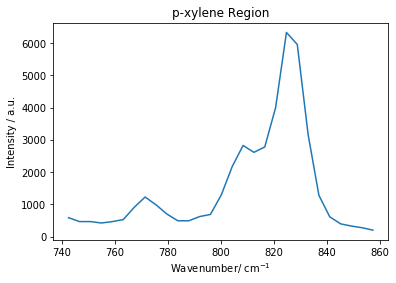

In [3]:
# Extract relevant p-xylene region and Vinyl region from the 1st spectra for
# baseline correction and plot tests.

pxyl_Region = df.iloc[0, 151:180] # Extract 1st spectra at the pxyl region and plot.
pxyl_Region.index = pxyl_Region.index.astype(float) # Change the index type to float.
pxyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
plt.show()

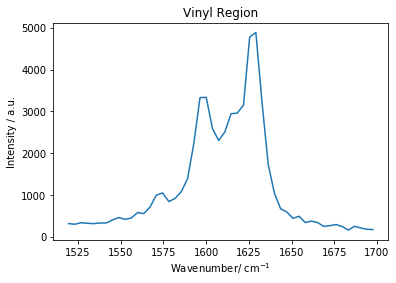

In [4]:
Vinyl_Region = df.iloc[0, 350:400] # Extract 1st spectra at the Vinyl region and plot.
Vinyl_Region.index = Vinyl_Region.index.astype(float) # Change the index type to float.
Vinyl_Region.plot()
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
plt.show()

# Baseline Subtraction

## Custom

Choose two regions on the spectrum that you want to form the basis for the baseline. The spectrum is based on the truncated region of interest from the raw spectrum.

Choose from the curve above, <10 and >50 to form the x and y values to fit a polynomial line, serving as my baseline values. **Note that the x-axis is the placeholder index location of the truncated spectra, not the actual wavenumbers themselves**

p-xylene Region Baseline Subtraction

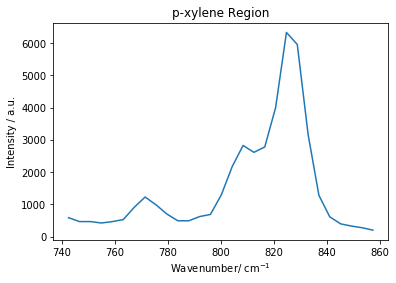

In [5]:
# p-xylene Region Baseline Subtraction
y = df.iloc[0, 151:180]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region')
y.plot()
plt.show()

# y is a Series. A pandas Series is a lablled/ indexed 1-D array. Therefore, a single argument of y,
# itself containing the intensity value (y-axis) at the corresponding wavenumber (x-axis) can be plotted. 

# Plot the 1st spectra (1st row) of df_t0.

In [6]:
xbl = [] # x-baseline.

for items in y.index[:5].values.tolist():
    xbl.append(items)

for items in y.index[25:].values.tolist():
    xbl.append(items)

# Recall that y is a Series with intensities labelled by their wavenumbers. y.index gives the Series labels, which are the 
# wavenumbers. y.index[:10] gives the 0th to 9th Series labels and is an index object. Convert the index object to a numpy
# array via y.index[:10].values, then put them into a list via y.index[:10].values.tolist().

# There are 2 for loops for the xbl (x baseline) list because you want the 1st 10 wavenumbers, but you also want the last
# wavenumbers from index 40 onwards. In the end, xbl is a single list containing all wavenumbers from index 0 to 9,
# and then from index 40 onwards. The same ideas apply for ybl, except for the fact that ybl contains intensities.

ybl = [] # y-baseline.

for items in y.values[:5].tolist():
    ybl.append(items)

for items in y.values[25:].tolist():
    ybl.append(items)
    
# y is a Pandas Series. Therefore, y.values immediately gives the values witihn that series, which are the intensities.

In [7]:
# Check that the range of xbl and ybl values makes sense.
xbl_and_ybl = list(zip(xbl, ybl))# Zip xbl and ybl together, then use list function to unpack the zipped object.
xbl_and_ybl

[(742.492828, 585.0),
 (746.621203, 463.0),
 (750.74967, 464.0),
 (754.876246, 420.0),
 (758.998952, 463.0),
 (845.036073, 394.0),
 (849.105859, 325.0),
 (853.173798, 273.0),
 (857.23989, 199.0)]

Running the baseline fit. **(x-values, y-values, polynomial degree)** are the arguments.

In [8]:
blpars = np.polyfit(xbl, ybl, 1)
# blpars contains the baseline parameters; the coefficients which will allow for the baseline polynomial to be defined.
# Fit a polynomial based on the x and y-values chosen for the spectra during the previous step. Thus, given a list of x values
# and its corresponding y-values, fit a polynomial through these points as best as you can. This polynomial will serve as the 
# baseline to be subtracted from the spectra's y-values. 
# numpy.polyfit(x, y, deg)
# np.polyfit: Least squares polynomial fit. Fit a polynomial p(x) = p[0] * x**deg + ... + p[deg] of degree deg to points (x, y).
# Returns a vector of coefficients p that minimises the squared error in the order deg, deg-1, … 0.
# Since degree = 1, we are fitting a straight line.

blfit = np.poly1d(blpars)
# A one-dimensional polynomial class. A convenience class, used to encapsulate “natural” operations on polynomials so that
# said operations may take on their customary form in code. blfit is a function that encompasses information on blpar's vector
# of coefficients derived from the np.polyfit step. It will take an input of x-values, then apply the coefficients to the
# x-values to obtain the best fit polynomial following the p(x) equation defined above.

Plot showing before and after subtraction.

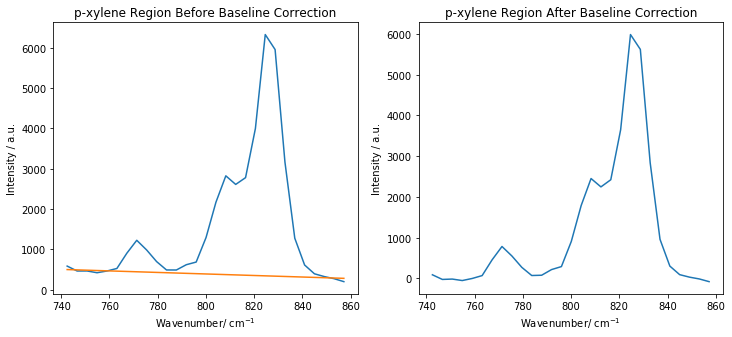

In [9]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1) # subplot(nrows, ncols, index)
plt.plot(y) # Plot the spectrum using the Series y.
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region Before Baseline Correction')
plt.plot(y.index, blfit(y.index))
# Plot the baseline polynomial to be subtracted (orange color). The x-axis will contain the wavenumbers. 
# Therefore y.index(Series labels) is being plotted at the x-axis. The y-axis will be blfit(y.index) because the output of 
# blfit(y.index) contains the y-values of the polynomial that is best fit to the input x-values.

plt.subplot(1,2,2)
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('p-xylene Region After Baseline Correction')
plt.plot(y.index,(y - blfit(y.index)))
# Plot the baseline corrected spectrum. Subtraction can immediately be done because blfit(y.index) is a numpy array of y-values
# of the best fit polynomial. So the each value in Series y will minus each value in array blfit(y.index),
# to yield a final y value, which is the corrected spectra intensity. 

plt.show()

Vinyl Region Baseline Subtraction

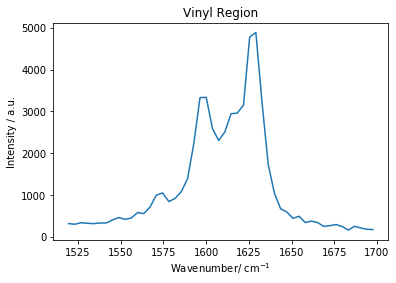

In [10]:
# Vinyl Region Baseline Subtraction
y = df.iloc[0, 350:400]
y.index = y.index.astype('float')
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region')
y.plot()
plt.show()

In [11]:
xbl = []

for items in y.index[:10].values.tolist():
    xbl.append(items)

for items in y.index[40:].values.tolist():
    xbl.append(items)
    
ybl = []

for items in y.values[:10].tolist():
    ybl.append(items)

for items in y.values[40:].tolist():
    ybl.append(items)

In [12]:
xbl_and_ybl = list(zip(xbl, ybl))
xbl_and_ybl

[(1519.413559, 317.0),
 (1523.101203, 302.0),
 (1526.785456, 338.0),
 (1530.468135, 324.0),
 (1534.149242, 316.0),
 (1537.826964, 331.0),
 (1541.504929, 332.0),
 (1545.179513, 404.0),
 (1548.85072, 462.0),
 (1552.522172, 418.0),
 (1665.287218, 341.0),
 (1668.89313, 250.0),
 (1672.495738, 267.0),
 (1676.098611, 295.0),
 (1679.696401, 247.0),
 (1683.294458, 161.0),
 (1686.88922, 252.0),
 (1690.48247, 212.0),
 (1694.074208, 181.0),
 (1697.664435, 174.0)]

In [13]:
blpars = np.polyfit(xbl, ybl, 1)
blfit = np.poly1d(blpars)

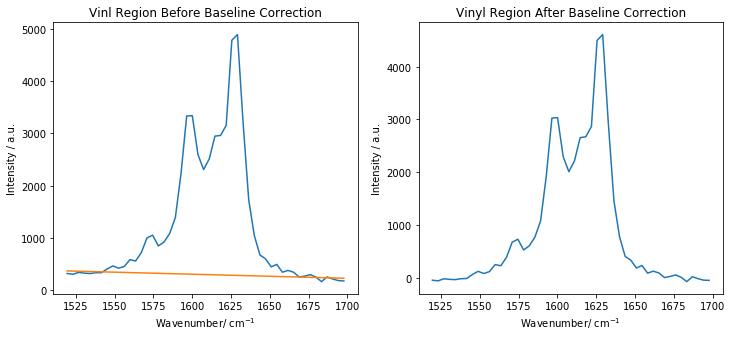

In [14]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.plot(y)
plt.plot(y.index, blfit(y.index))
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinl Region Before Baseline Correction')

plt.subplot(1,2,2)
plt.plot(y.index,(y - blfit(y.index))) 
plt.xlabel('Wavenumber/ cm$^{-1}$')
plt.ylabel('Intensity / a.u.')
plt.title('Vinyl Region After Baseline Correction')

plt.show()

# Fitting Functions

In [15]:
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian, split_lorentzian

def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']))
    
    return model - y

# Running Curve Fits

In [16]:
df_vinyl = df.iloc[:, 350:400].copy()
df_vinyl.columns = df_vinyl.columns.astype('float')
df_vinyl

1519.413559  1523.101203  1526.785456  1530.468135  1534.149242  \
0          317.0        302.0        338.0        324.0        316.0   
1          390.0        354.0        338.0        328.0        231.0   
2          311.0        324.0        363.0        280.0        294.0   
3          329.0        263.0        361.0        234.0        355.0   
4          378.0        320.0        364.0        331.0        309.0   
..           ...          ...          ...          ...          ...   
130        299.0        274.0        351.0        255.0        260.0   
131        307.0        301.0        349.0        281.0        301.0   
132        375.0        327.0        333.0        291.0        291.0   
133        310.0        313.0        366.0        321.0        305.0   
134        341.0        304.0        346.0        247.0        312.0   

     1537.826964  1541.504929  1545.179513  1548.850720  1552.522172  ...  \
0          331.0        332.0        404.0        462.0        418.0  ...   
1          306.0        329.0        379.0        396.0        439.0  ...   
2          322.0        305.0        342.0        441.0        389.0  ...   
3          351.0        333.0        321.0        503.0        390.0  ...   
4          298.0        366.0        376.0        458.0        378.0  ...   
..           ...          ...          ...          ...          ...  ...   
130        394.0        384.0        421.0        423.0        387.0  ...   
131        309.0        332.0        373.0        447.0        448.0  ...   
132        333.0        377.0        418.0        437.0        441.0  ...   
133        361.0        348.0        420.0        450.0        455.0  ...   
134        373.0        375.0        366.0        429.0        429.0  ...   

     1665.287218  1668.893130  1672.495738  1676.098611  1679.696401  \
0          341.0        250.0        267.0        295.0        247.0   
1          354.0        264.0        279.0        320.0        236.0   
2          369.0        271.0        251.0        297.0        260.0   
3          286.0        204.0        231.0        283.0        250.0   
4          296.0        268.0        237.0        297.0        232.0   
..           ...          ...          ...          ...          ...   
130        366.0        260.0        275.0        331.0        199.0   
131        301.0        305.0        283.0        320.0        242.0   
132        336.0        248.0        255.0        248.0        175.0   
133        387.0        275.0        226.0        296.0        238.0   
134        365.0        275.0        279.0        350.0        250.0   

     1683.294458  1686.889220  1690.482470  1694.074208  1697.664435  
0          161.0        252.0        212.0        181.0        174.0  
1          196.0        270.0        231.0        196.0        202.0  
2          243.0        242.0        216.0        193.0        193.0  
3          193.0        210.0        158.0        155.0        182.0  
4          197.0        270.0        234.0        173.0        206.0  
..           ...          ...          ...          ...          ...  
130        210.0        277.0        182.0        133.0        201.0  
131        162.0        260.0        217.0        154.0        239.0  
132        183.0        217.0        239.0        179.0        245.0  
133        242.0        263.0        211.0        173.0        202.0  
134        213.0        294.0        232.0        190.0        208.0  

[135 rows x 50 columns]

For 2 Lorentzians peak fits within the region of interest:

## Select initial guess parameters, namely amplitude, centre, width of the peaks.

In [17]:
ampL1 = 100000 # Peak Amplitude of 1st Peak
cenL1 = 1599 # Peak location of 1st Peak
widL1 = 10

ampL2 = 100000 # Peak Amplitude of 2nd Peak
cenL2 = 1627 # Peak location of 2nd Peak
widL2 = 6

## Fitting and Plotting (Vinyl Region)

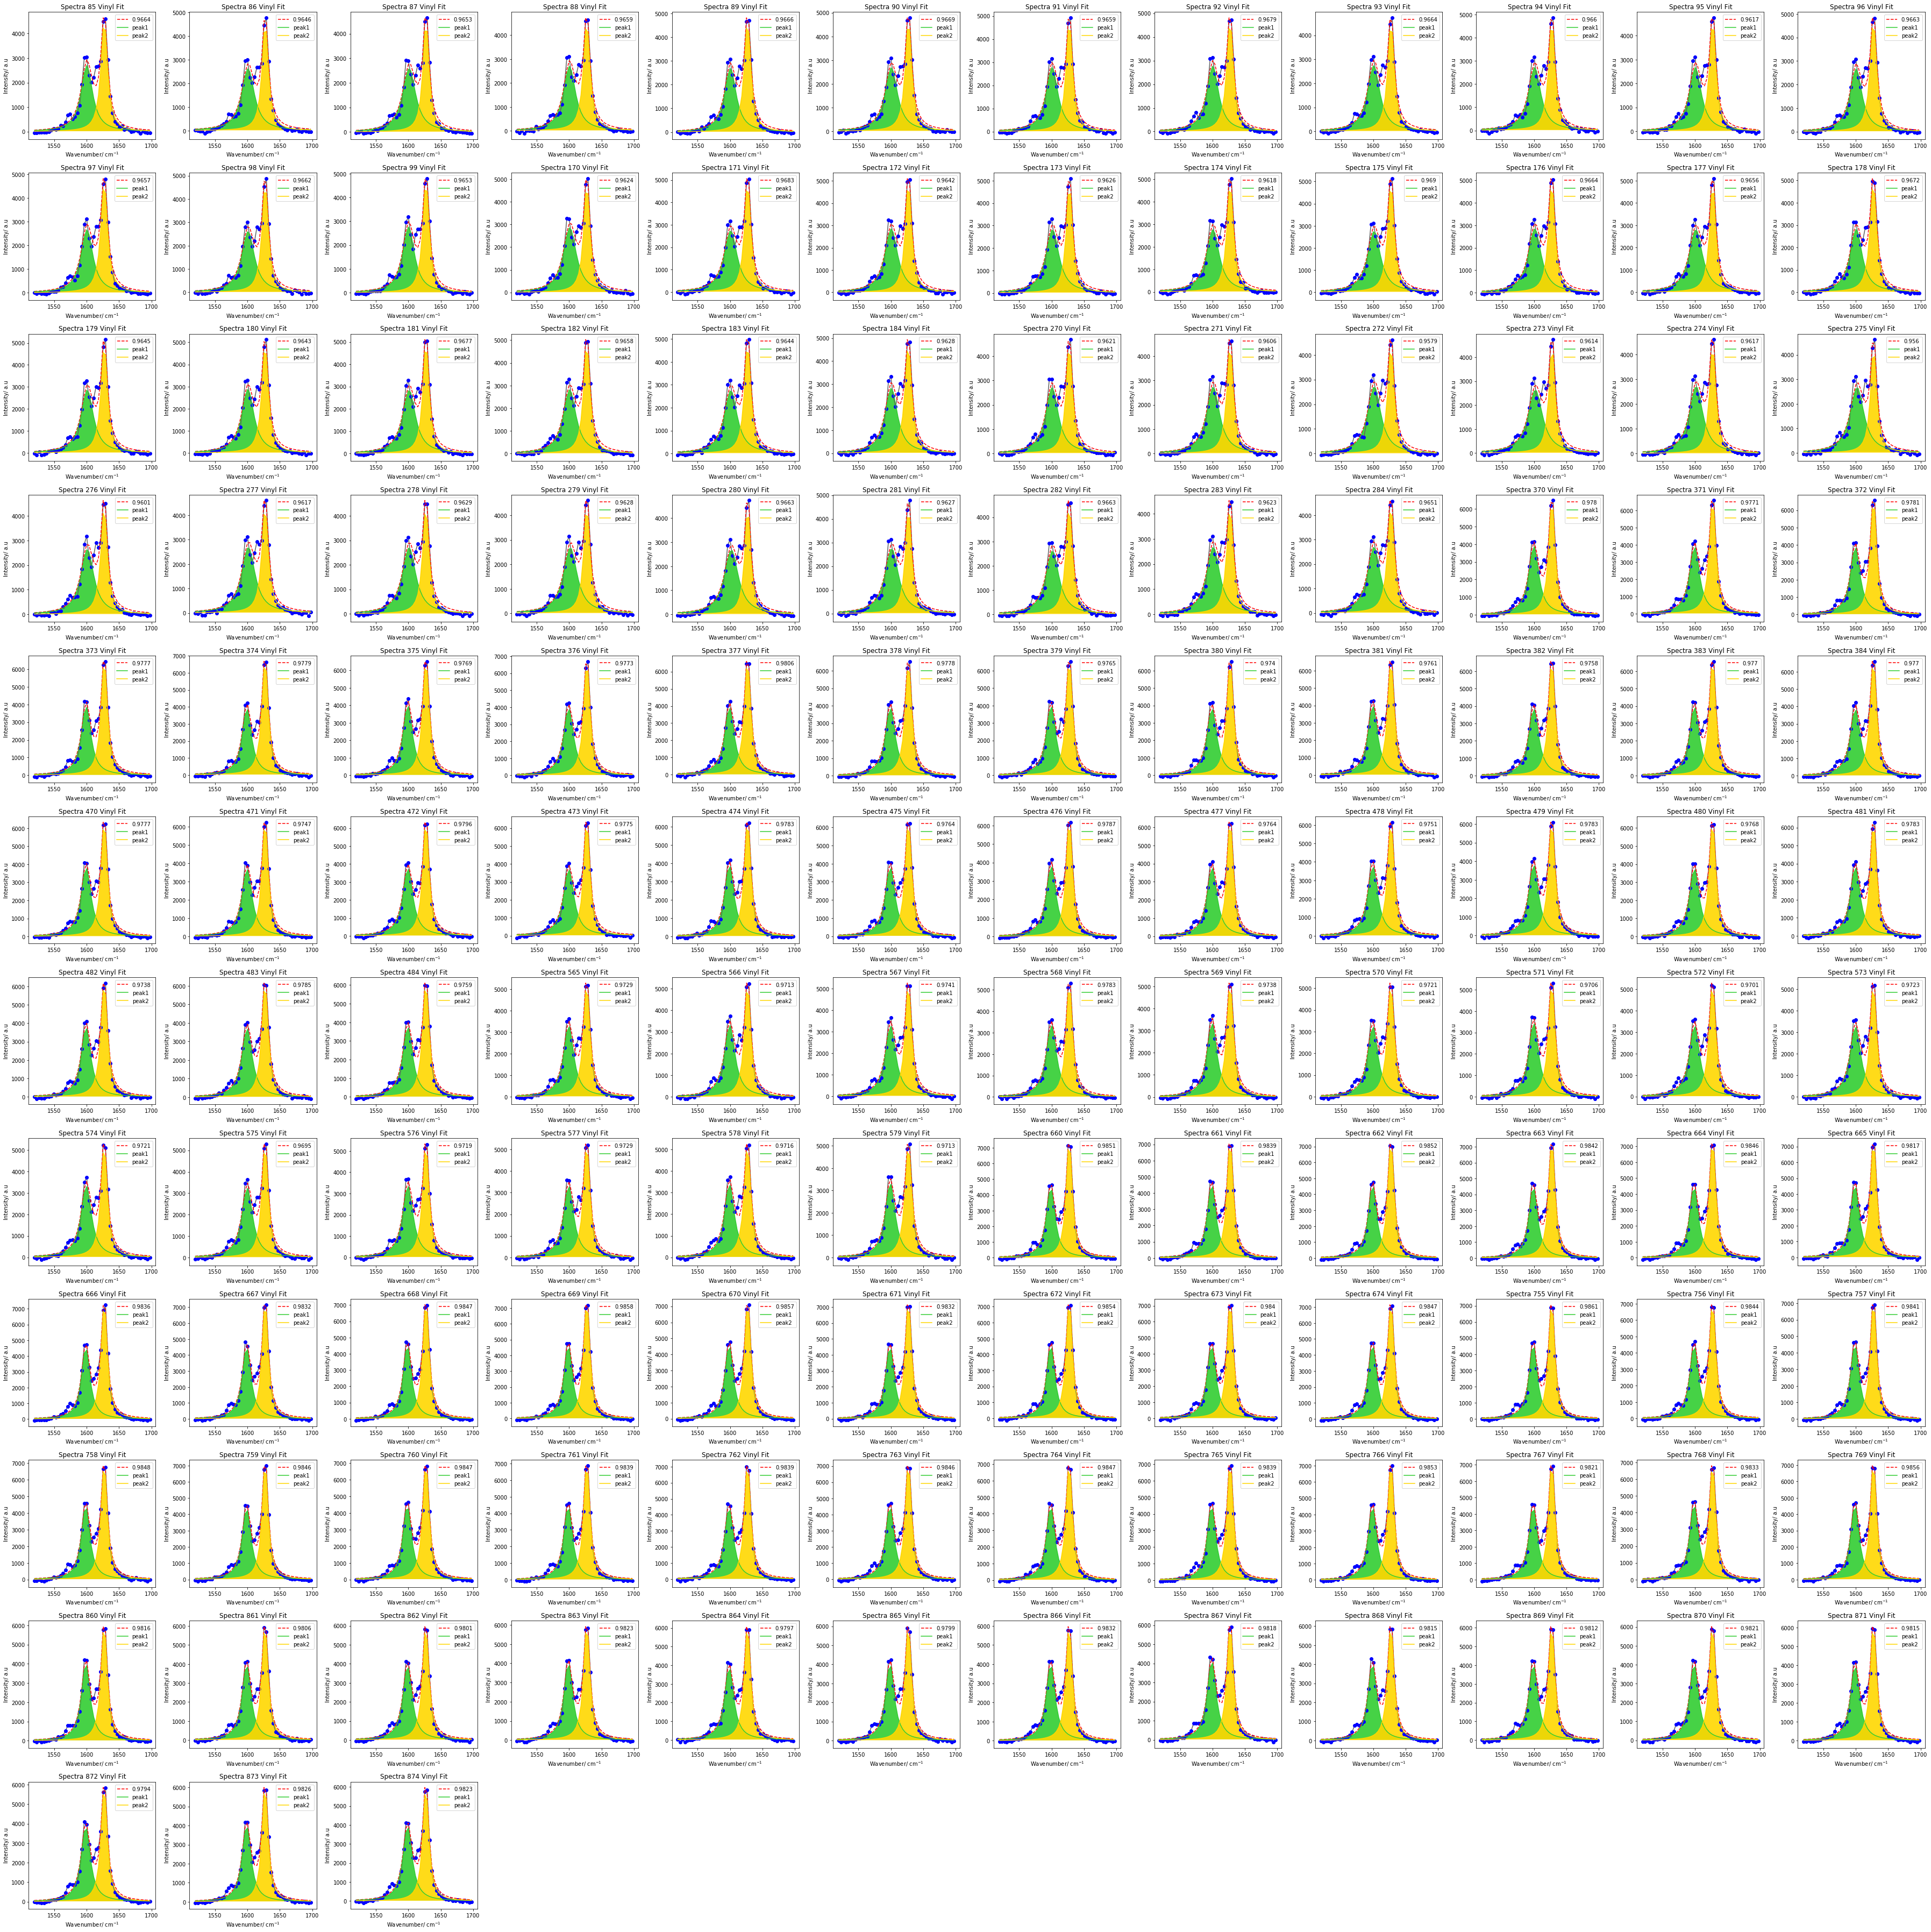

In [18]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])

pbar = tqdm(total = len(df_vinyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='cenL1', value = cenL1, max = 1605)
pfit.add(name='cenL2', value = cenL2, min = 1620, max = 1640)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)

for i,item in df_vinyl.iterrows():
    
    x = df_vinyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:10].values.tolist():
        xbl.append(items)

    for items in y.index[40:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:10].tolist():
        ybl.append(items)

    for items in y.values[40:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['Height_L1'] = 0.3183099*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.3183099*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    
    plt.subplot(np.ceil(np.sqrt(df_vinyl.shape[0])),np.ceil(np.sqrt(df_vinyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' Vinyl Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    
    pbar.update(1)
    
pbar.close()
    
plt.tight_layout()
plt.show()

In [19]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_Vinyl'}, inplace=True)
results.describe()

ampL1          ampL2        cenL1        cenL2       widL1  \
count     135.000000     135.000000   135.000000   135.000000  135.000000   
mean   106029.059623  107398.612203  1599.658924  1627.172110    9.782643   
std      5946.960326   17957.466486     1.070380     0.097583    1.613955   
min     91123.359672   75028.397049  1598.391718  1626.953985    7.625234   
25%    102380.695768   90118.026758  1598.698458  1627.100253    8.295762   
50%    106968.882889  110038.850752  1599.259328  1627.165114    9.283329   
75%    110776.667499  123349.508945  1600.714514  1627.241862   11.390023   
max    115829.301110  134157.525537  1602.171198  1627.489140   13.321074   

            widL2    R2_Vinyl     FWHM_L1     FWHM_L2    Height_L1  \
count  135.000000  135.000000  135.000000  135.000000   135.000000   
mean     5.870384    0.974400   19.565286   11.740768  3554.645133   
std      0.178172    0.008226    3.227910    0.356344   674.235320   
min      5.451322    0.956017   15.250468   10.902644  2592.493837   
25%      5.735988    0.966318   16.591524   11.471976  2793.412252   
50%      5.849485    0.976361   18.566659   11.698971  3741.058203   
75%      5.990339    0.981932   22.780047   11.980678  3991.800867   
max      6.360419    0.986120   26.642148   12.720838  4584.723751   

         Height_L2  
count   135.000000  
mean   5837.318135  
std    1045.414218  
min    4230.132082  
25%    4835.108228  
50%    6042.236747  
75%    6671.693596  
max    7481.995700

For 2 Lorentzians peak fits within the region of interest:

In [20]:
Area_2 = pd.Series(Area_2)
labels = df.iloc[:, 0:2]
df_area = pd.concat([labels, Area_2, results['R2_Vinyl']], axis=1)
df_area.rename(columns={0: 'Vinyl Peak Area'}, inplace=True)
df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl
0                85          1     84531.783447  0.966364
1                86          1     80309.644708  0.964617
2                87          1     76914.708073  0.965327
3                88          1     84551.231714  0.965903
4                89          1     86044.207299  0.966606
..              ...        ...              ...       ...
130             870          9    105549.101864  0.982081
131             871          9    105577.802582  0.981480
132             872          9    103652.601208  0.979382
133             873          9    104515.415428  0.982620
134             874          9    102371.142328  0.982320

[135 rows x 4 columns]

# Fitting and Plotting (p-xylene Region)

In [21]:
df_pxyl = df.iloc[:, 151:180].copy()
df_pxyl.columns = df_pxyl.columns.astype('float')
df_pxyl

742.492828  746.621203  750.749670  754.876246  758.998952  763.119771  \
0         585.0       463.0       464.0       420.0       463.0       526.0   
1         598.0       509.0       445.0       332.0       473.0       503.0   
2         497.0       458.0       472.0       375.0       441.0       502.0   
3         511.0       415.0       396.0       348.0       376.0       506.0   
4         577.0       456.0       413.0       409.0       386.0       539.0   
..          ...         ...         ...         ...         ...         ...   
130       621.0       573.0       535.0       584.0       628.0       774.0   
131       631.0       525.0       584.0       515.0       594.0       750.0   
132       668.0       525.0       589.0       550.0       563.0       712.0   
133       664.0       539.0       574.0       559.0       636.0       790.0   
134       749.0       577.0       628.0       580.0       644.0       732.0   

     767.238706  771.353779  775.466971  779.578284  ...  820.560786  \
0         904.0      1225.0       984.0       697.0  ...      3999.0   
1         872.0      1248.0      1089.0       685.0  ...      3966.0   
2         871.0      1213.0      1048.0       680.0  ...      4114.0   
3         876.0      1206.0       998.0       660.0  ...      3988.0   
4         901.0      1281.0      1086.0       674.0  ...      4053.0   
..          ...         ...         ...         ...  ...         ...   
130      1157.0      1691.0      1323.0       818.0  ...      3438.0   
131      1192.0      1724.0      1317.0       885.0  ...      3401.0   
132      1214.0      1626.0      1392.0       883.0  ...      3401.0   
133      1244.0      1632.0      1412.0       876.0  ...      3428.0   
134      1123.0      1657.0      1315.0       935.0  ...      3344.0   

     824.643659  828.726638  832.807761  836.887027  840.962476  845.036073  \
0        6329.0      5957.0      3166.0      1277.0       612.0       394.0   
1        6485.0      5818.0      3244.0      1251.0       654.0       440.0   
2        6422.0      6006.0      3221.0      1302.0       559.0       342.0   
3        6438.0      6047.0      3179.0      1281.0       564.0       381.0   
4        6390.0      6014.0      3324.0      1211.0       648.0       373.0   
..          ...         ...         ...         ...         ...         ...   
130      5270.0      4699.0      2505.0      1096.0       646.0       444.0   
131      5372.0      4738.0      2700.0      1051.0       648.0       450.0   
132      5228.0      4707.0      2552.0      1124.0       650.0       435.0   
133      5374.0      4706.0      2611.0      1144.0       672.0       414.0   
134      5233.0      4843.0      2514.0      1152.0       621.0       465.0   

     849.105859  853.173798  857.239890  
0         325.0       273.0       199.0  
1         331.0       280.0       267.0  
2         324.0       276.0       245.0  
3         372.0       366.0       229.0  
4         351.0       363.0       247.0  
..          ...         ...         ...  
130       373.0       340.0       293.0  
131       319.0       350.0       279.0  
132       433.0       348.0       301.0  
133       480.0       347.0       260.0  
134       411.0       386.0       271.0  

[135 rows x 29 columns]

In [22]:
def residuals(pars,x,y):
    
    model =  (lorentzian(x, pars['ampL1'], pars['cenL1'], pars['widL1']) +
              lorentzian(x, pars['ampL2'], pars['cenL2'], pars['widL2']) +
              split_lorentzian(x, pars['ampL3'], pars['cenL3'], pars['widL3'],pars['widL4']))
    
    return model - y

In [23]:
ampL1 = 14000
cenL1 = 772 
widL1 = 3

ampL2 = 27000 
cenL2 = 808
widL2 = 5

ampL3 = 100000
cenL3 = 826
widL3 = 7
widL4 = 4

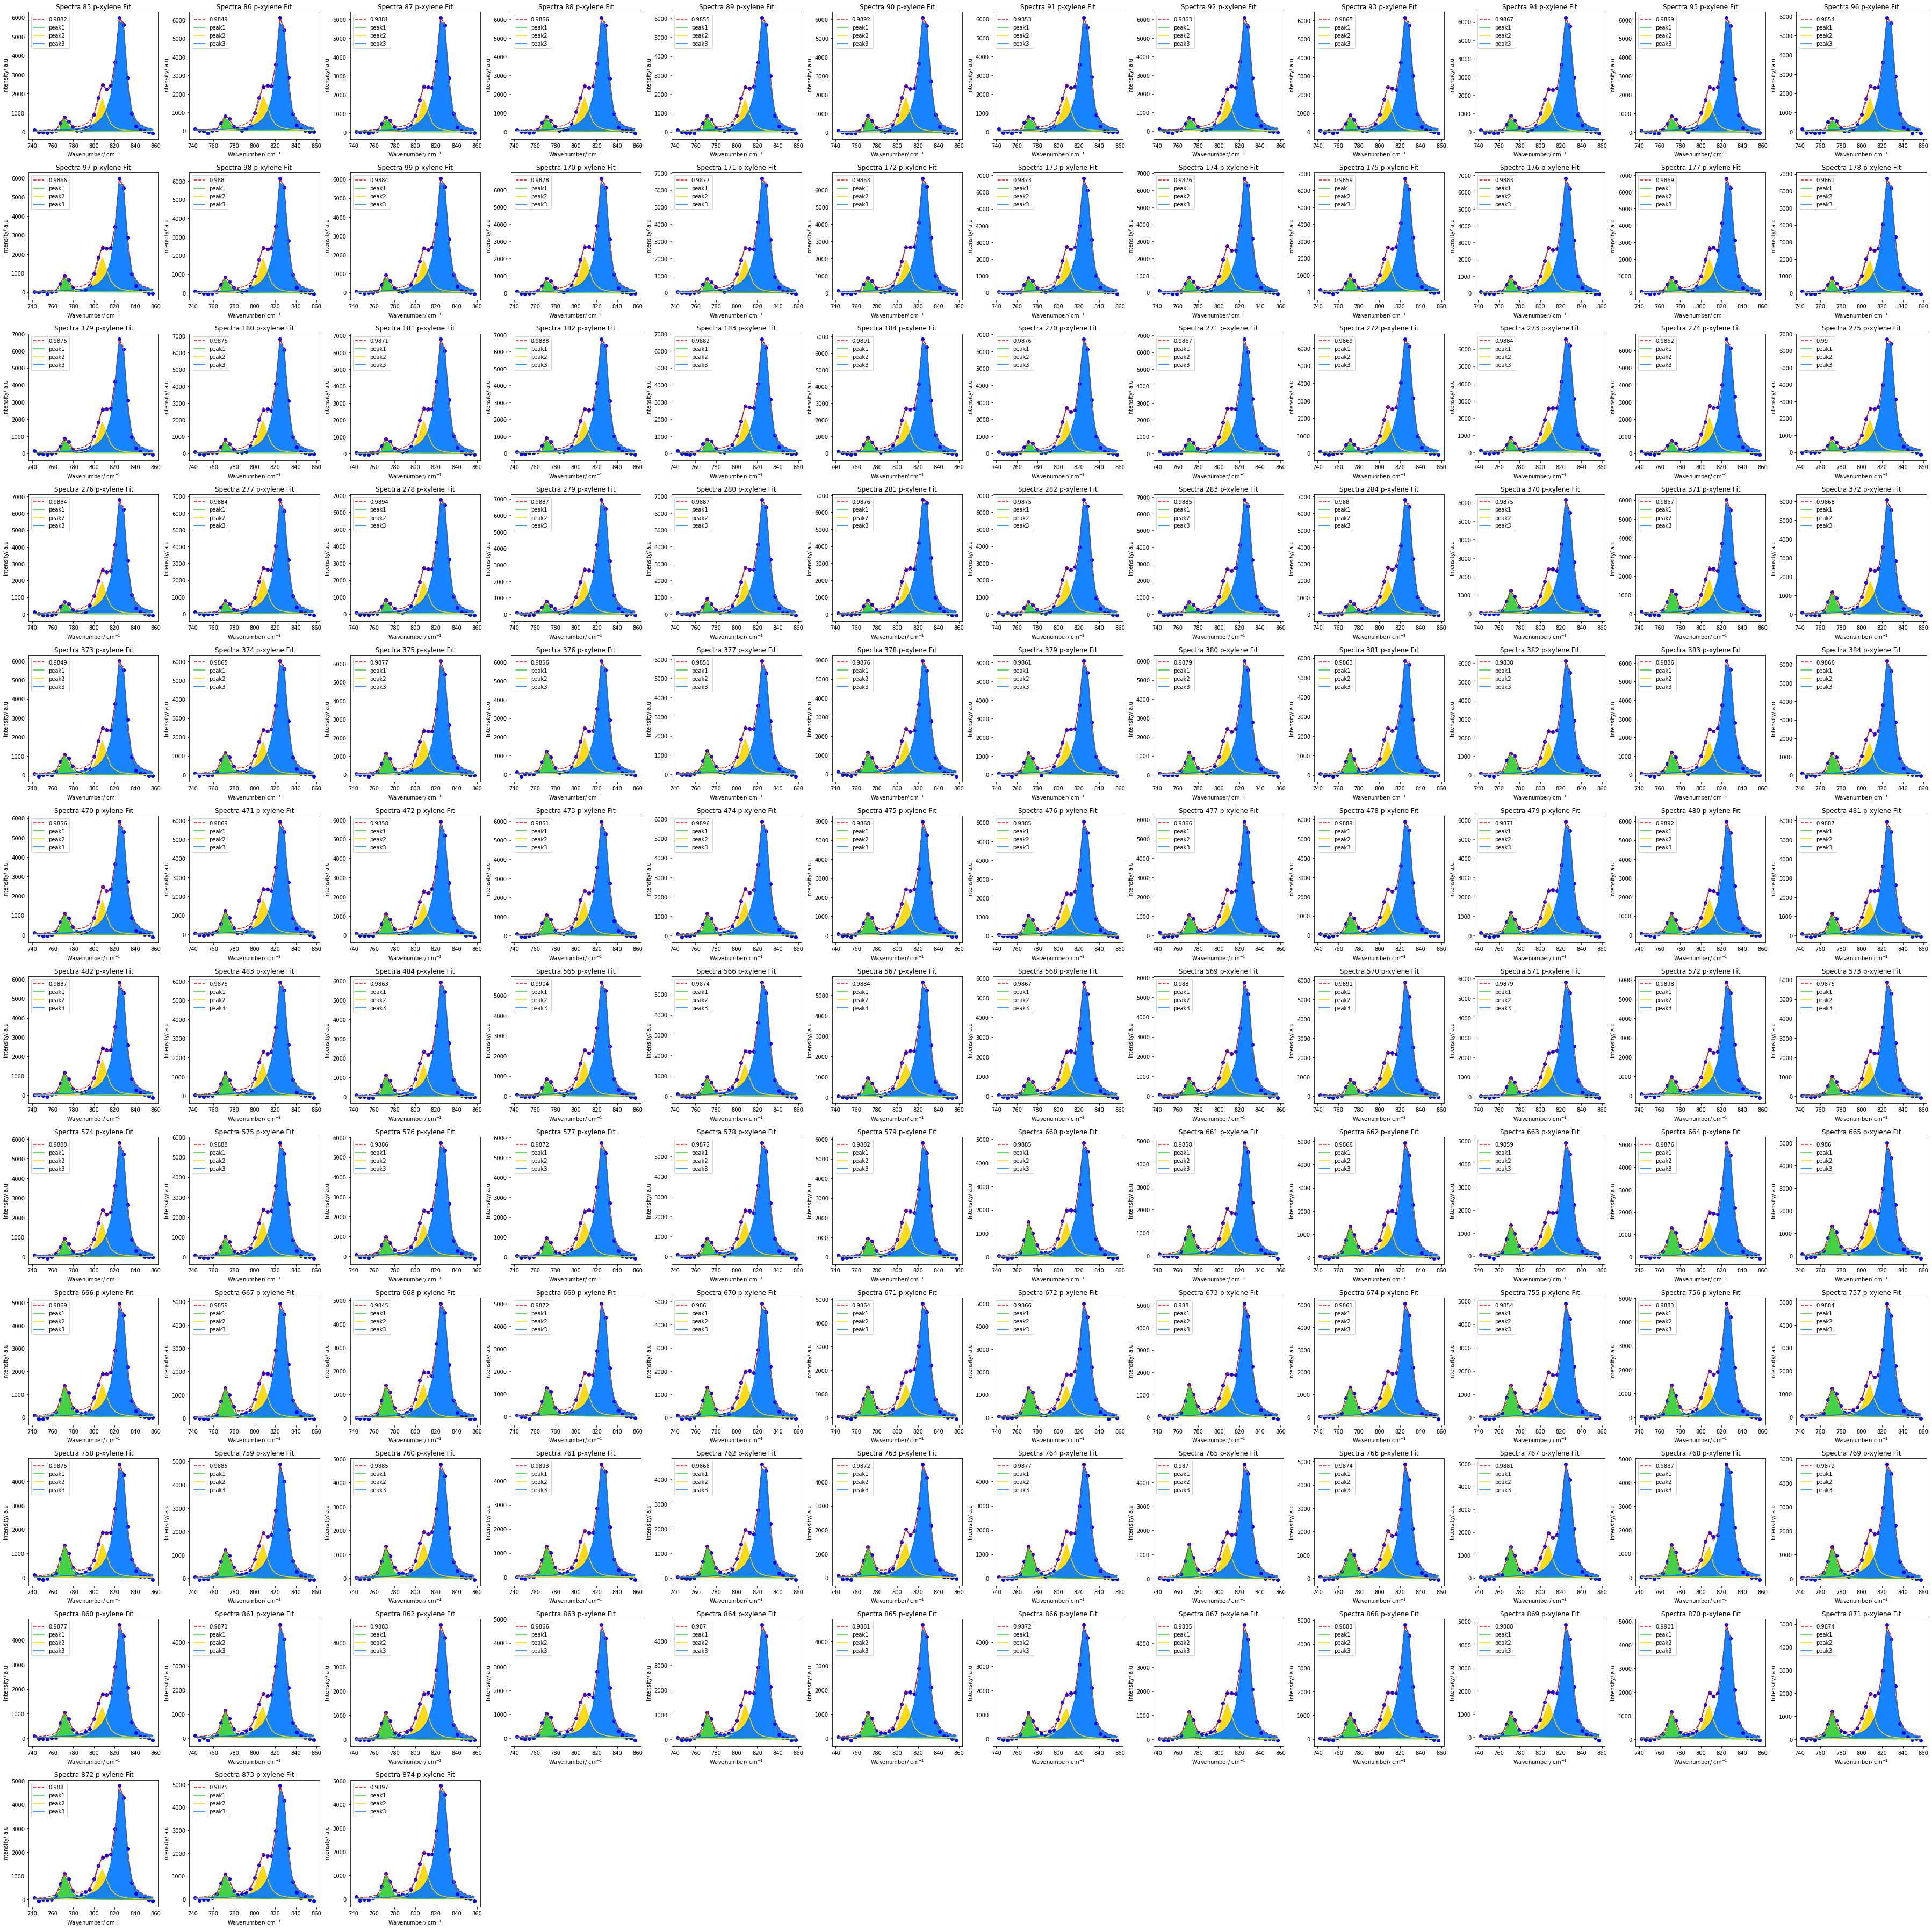

In [24]:
de = collections.deque([])
Area_1 = collections.deque([])
Area_2 = collections.deque([])
Area_3 = collections.deque([])

pbar = tqdm(total = len(df_pxyl), dynamic_ncols  = True, desc = 'Fitting curves')

plt.figure(figsize = (50,50))

pfit = Parameters()
pfit.add(name='ampL1', value = ampL1, min = 0)
pfit.add(name='ampL2', value = ampL2, min = 0)
pfit.add(name='ampL3', value = ampL3, min = 0)
pfit.add(name='cenL1', value = cenL1, min = 770, max = 780)
pfit.add(name='cenL2', value = cenL2, min = 805, max = 815)
pfit.add(name='cenL3', value = cenL3, min = 820, max = 830)
pfit.add(name='widL1', value = widL1, min = 0)
pfit.add(name='widL2', value = widL2, min = 0)
pfit.add(name='widL3', value = widL3, min = 0)
pfit.add(name='widL4', value = widL4, min = 0)

for i,item in df_pxyl.iterrows():
    
    x = df_pxyl.columns # Wavenumbers
    
    y = item # Intensities
    
    xbl = []

    for items in y.index[:5].values.tolist():
        xbl.append(items)

    for items in y.index[25:].values.tolist():
        xbl.append(items)


    ybl = []

    for items in y.values[:5].tolist():
        ybl.append(items)

    for items in y.values[25:].tolist():
        ybl.append(items)
    
    blpars = np.polyfit(xbl, ybl, 1)
    blfit = np.poly1d(blpars)
    
    y -= blfit(x) # Corrected Intensities

    mini = Minimizer(residuals, pfit, fcn_args=(x, y))
    out = mini.leastsq()
    best_fit = y + out.residual
    
    fit_params = out.params.valuesdict()
    fit_params['R2'] = r2_score(y,best_fit)
    fit_params['FWHM_L1'] = 2*out.params.valuesdict()['widL1']
    fit_params['FWHM_L2'] = 2*out.params.valuesdict()['widL2']
    fit_params['FWHM_L3'] = out.params.valuesdict()['widL3'] + out.params.valuesdict()['widL4']
    fit_params['Height_L1'] = 0.318309886*out.params.valuesdict()['ampL1']/max(2.220446049250313e-16, out.params.valuesdict()['widL1'])
    fit_params['Height_L2'] = 0.318309886*out.params.valuesdict()['ampL2']/max(2.220446049250313e-16, out.params.valuesdict()['widL2'])
    fit_params['Height_L3'] = 0.318309886*out.params.valuesdict()['ampL3']/max(2.220446049250313e-16, out.params.valuesdict()['widL3']+out.params.valuesdict()['widL4'])
    
    results = de.append(fit_params)
    
    peak1 = lorentzian(x,out.params.valuesdict()['ampL1'], out.params.valuesdict()['cenL1'], out.params.valuesdict()['widL1'])
    peak2 = lorentzian(x,out.params.valuesdict()['ampL2'], out.params.valuesdict()['cenL2'], out.params.valuesdict()['widL2'])
    peak3 = split_lorentzian(x,out.params.valuesdict()['ampL3'], out.params.valuesdict()['cenL3'], out.params.valuesdict()['widL3'], out.params.valuesdict()['widL4'])
    
    plt.subplot(np.ceil(np.sqrt(df_pxyl.shape[0])),np.ceil(np.sqrt(df_pxyl.shape[0])),(1+i))
    plt.title('Spectra ' + str(df.loc[i, 'Original Index']) + ' p-xylene Fit')
    plt.xlabel('Wavenumber/ cm$^{-1}$')
    plt.ylabel('Intensity/ a.u')
    plt.plot(x, y, '#606060')
    plt.plot(x, y, 'bo')
    plt.plot(x, best_fit, 'r--', label = str(fit_params['R2'].round(decimals = 4)))
    plt.plot(x, peak1,'#32CD32', label = 'peak1')
    plt.fill_between(x, peak1.min(), peak1, facecolor = '#32CD32', alpha = 0.9)
    plt.plot(x, peak2,'#FFD700', label = 'peak2')
    plt.fill_between(x, peak2.min(), peak2, facecolor = '#FFD700', alpha = 0.9)
    plt.plot(x, peak3,'#0077FF', label = 'peak3')
    plt.fill_between(x, peak3.min(), peak3, facecolor = '#0077FF', alpha = 0.9)
    plt.legend(loc='best')
   
    Area_1.append(integrate.simps(peak1, x)) 
    Area_2.append(integrate.simps(peak2, x))
    Area_3.append(integrate.simps(peak3, x))
    
    pbar.update(1)
    
plt.tight_layout()
plt.show()

In [25]:
results = pd.DataFrame(de)
results.rename(columns={'R2':'R2_pxyl'}, inplace=True)
results.describe()

ampL1         ampL2          ampL3       cenL1       cenL2  \
count     135.000000    135.000000     135.000000  135.000000  135.000000   
mean    14290.686802  27751.101212  106335.032484  772.623396  808.255035   
std     18785.844047   3324.391543   14521.463592    0.355475    0.313823   
min      5940.578773  18064.151047   82336.725121  771.715300  806.999158   
25%      8321.036641  25191.012500   89964.971748  772.379280  808.097418   
50%     11806.925488  27930.795522  109192.449757  772.615618  808.249847   
75%     14410.433527  30344.543564  115205.296863  772.940800  808.467276   
max    161915.442731  35838.234770  130098.738574  773.282993  808.889214   

            cenL3       widL1       widL2       widL3       widL4     R2_pxyl  \
count  135.000000  135.000000  135.000000  135.000000  135.000000  135.000000   
mean   826.877163    2.790206    5.235162    6.579886    4.334420    0.987430   
std      0.127167    0.930171    0.285352    0.255366    0.091061    0.001251   
min    826.543132    0.039320    4.143419    5.987789    4.025495    0.983849   
25%    826.800776    2.283409    5.064561    6.411269    4.270752    0.986607   
50%    826.880727    2.970362    5.200477    6.570087    4.348059    0.987482   
75%    826.960551    3.505242    5.407184    6.781325    4.386808    0.988384   
max    827.222389    4.209978    6.066877    7.294110    4.542612    0.990365   

          FWHM_L1     FWHM_L2     FWHM_L3     Height_L1    Height_L2  \
count  135.000000  135.000000  135.000000  1.350000e+02   135.000000   
mean     5.580412   10.470324   10.914306  2.051478e+04  1690.963770   
std      1.860342    0.570704    0.265630  1.354111e+05   212.218218   
min      0.078640    8.286837   10.266959  6.642219e+02  1258.540057   
25%      4.566819   10.129121   10.726902  1.111487e+03  1474.203582   
50%      5.940724   10.400953   10.916281  1.275003e+03  1725.365334   
75%      7.010485   10.814367   11.130706  1.404668e+03  1844.809041   
max      8.419956   12.133753   11.607766  1.310769e+06  2090.689278   

         Height_L3  
count   135.000000  
mean   3099.803837  
std     405.663764  
min    2464.911809  
25%    2641.092580  
50%    3184.628231  
75%    3326.233508  
max    3758.692406

In [26]:
df_area = pd.concat([df_area, pd.Series(Area_3), results['R2_pxyl']], axis=1)
df_area.rename(columns={0: 'pxyl Peak Area'}, inplace=True)
df_area

Original Index  Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0                85          1     84531.783447  0.966364   107634.840176   
1                86          1     80309.644708  0.964617   102123.393250   
2                87          1     76914.708073  0.965327   108151.755141   
3                88          1     84551.231714  0.965903   105769.049681   
4                89          1     86044.207299  0.966606   108263.425595   
..              ...        ...              ...       ...             ...   
130             870          9    105549.101864  0.982081    84131.499461   
131             871          9    105577.802582  0.981480    84022.848390   
132             872          9    103652.601208  0.979382    82607.879038   
133             873          9    104515.415428  0.982620    82371.188630   
134             874          9    102371.142328  0.982320    81556.756774   

      R2_pxyl  
0    0.988232  
1    0.984882  
2    0.988069  
3    0.986633  
4    0.985471  
..        ...  
130  0.990096  
131  0.987375  
132  0.987952  
133  0.987526  
134  0.989699  

[135 rows x 6 columns]

In [27]:
# Keep only columns with R2 values above a threshold.
df_area = df_area[(df_area['R2_Vinyl'] > 0.96) & (df_area['R2_pxyl'] > 0.96)]

# Normalization
df_area['Vinyl Divide pxyl'] =  df_area['Vinyl Peak Area'] / df_area['pxyl Peak Area']

df_area

C:\Users\Tan Jin Da\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Original Index  Condition  Vinyl Peak Area  R2_Vinyl  pxyl Peak Area  \
0                85          1     84531.783447  0.966364   107634.840176   
1                86          1     80309.644708  0.964617   102123.393250   
2                87          1     76914.708073  0.965327   108151.755141   
3                88          1     84551.231714  0.965903   105769.049681   
4                89          1     86044.207299  0.966606   108263.425595   
..              ...        ...              ...       ...             ...   
130             870          9    105549.101864  0.982081    84131.499461   
131             871          9    105577.802582  0.981480    84022.848390   
132             872          9    103652.601208  0.979382    82607.879038   
133             873          9    104515.415428  0.982620    82371.188630   
134             874          9    102371.142328  0.982320    81556.756774   

      R2_pxyl  Vinyl Divide pxyl  
0    0.988232           0.785357  
1    0.984882           0.786398  
2    0.988069           0.711174  
3    0.986633           0.799395  
4    0.985471           0.794767  
..        ...                ...  
130  0.990096           1.254573  
131  0.987375           1.256537  
132  0.987952           1.254754  
133  0.987526           1.268835  
134  0.989699           1.255214  

[133 rows x 7 columns]

In [28]:
# View the summary statistics
df_area_stats = df_area[['Condition', 'Vinyl Divide pxyl']].groupby('Condition').describe()
df_area_stats

Vinyl Divide pxyl                                                    \
                      count      mean       std       min       25%       50%   
Condition                                                                       
1                      15.0  0.793005  0.035387  0.711174  0.781354  0.794767   
2                      15.0  0.735534  0.016499  0.705767  0.724831  0.736027   
3                      13.0  0.651005  0.025769  0.609952  0.628664  0.645396   
4                      15.0  1.118009  0.033236  1.064229  1.099104  1.111223   
5                      15.0  1.086568  0.029531  1.055236  1.066408  1.081270   
6                      15.0  0.944667  0.026925  0.898837  0.921813  0.953985   
7                      15.0  1.504519  0.039192  1.432438  1.495212  1.503511   
8                      15.0  1.493556  0.040962  1.382243  1.492696  1.498730   
9                      15.0  1.286809  0.039720  1.238842  1.254984  1.278952   

                               
                75%       max  
Condition                      
1          0.805606  0.876172  
2          0.747985  0.759180  
3          0.675072  0.687285  
4          1.136223  1.192625  
5          1.097618  1.147531  
6          0.964281  0.986536  
7          1.526944  1.577112  
8          1.518765  1.551046  
9          1.309088  1.359436

In [29]:
mean = df_area_stats['Vinyl Divide pxyl', 'mean'].values
std = df_area_stats['Vinyl Divide pxyl', 'std'].values
condition = range(1,10)

In [30]:
df_ratio = pd.DataFrame({'Condition':condition, 'Mean Ratio':mean, 'Standard Deviation': std})
df_ratio

Condition  Mean Ratio  Standard Deviation
0          1    0.793005            0.035387
1          2    0.735534            0.016499
2          3    0.651005            0.025769
3          4    1.118009            0.033236
4          5    1.086568            0.029531
5          6    0.944667            0.026925
6          7    1.504519            0.039192
7          8    1.493556            0.040962
8          9    1.286809            0.039720

In [31]:
df_ratio.to_csv(r'C:\Users\Tan Jin Da\Desktop\High Throughput Experiments Data\201008 High Throughput Experiment Conditions 1 to 9\Online Raman\df_t90_ratio.csv')